# Particle Filter (PF) Demo

Demonstrates Particle Filter with non-linear Range-Bearing tracking:
- Linear motion (constant velocity)
- Non-linear observations (range/bearing in polar coordinates)

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from pf import ParticleFilter
from range_bearing_model import RangeBearingModel
import warnings
warnings.filterwarnings('ignore')

tfd = tfp.distributions
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow Probability version: {tfp.__version__}")

2025-11-18 18:20:57.498541: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.16.2
TensorFlow Probability version: 0.24.0


## 1. Generate Data

In [ ]:
# Create model and generate trajectory
dt = 1.0
model = RangeBearingModel(
    dt=dt, 
    process_noise_std_pos=0.1, 
    process_noise_std_vel=0.1,
    range_noise_std=50.0, 
    bearing_noise_std=0.005, 
    seed=42
)

T = 20
true_states, obs = model.simulate_trajectory(T=T)

print(f"Generated {T} observations")
print(f"True states: {true_states.shape}, Observations: {obs.shape}")

Generated 40 observations
True states: (4, 41), Observations: (2, 40)


## 2. Define Functions for Particle Filter

In [ ]:
# State transition: x_t = A @ x_{t-1}
def state_transition_fn(x, u=None):
    A_float64 = tf.cast(model.A, tf.float64)
    return tf.matmul(A_float64, x)

# Observation: z = [range, bearing]
def observation_fn(x):
    x_pos, y_pos = x[0, 0], x[2, 0]
    r = tf.sqrt(x_pos**2 + y_pos**2)
    theta = tf.atan2(y_pos, x_pos)
    return tf.stack([r, theta])[:, tf.newaxis]

# Process noise sampler: sample from N(0, Q)
def process_noise_sampler(num_samples):
    """Sample process noise from N(0, Q)"""
    noise = tf.random.normal([4, num_samples], dtype=tf.float64)
    Q_sqrt = tf.linalg.cholesky(tf.cast(model.Q, tf.float64))
    return tf.matmul(Q_sqrt, noise)

def observation_likelihood_fn(z, x):
    """Compute p(z|x) = N(z; h(x), R) - returns likelihood """
    # Predict observation from state
    z_pred = observation_fn(x)    
    v = z - z_pred

    R = tf.cast(model.R, tf.float64)
    R_inv = tf.linalg.inv(R)
    exponent = -0.5 * tf.matmul(tf.transpose(v), tf.matmul(R_inv, v))[0, 0]
    return tf.exp(exponent)
    

# Initial state sampler: sample from initial distribution
def x0_sampler(x0, Sigma0):
    """Create initial state sampler"""
    def sampler(num_samples):
        x0_flat = tf.reshape(x0, [-1])
        initial_dist = tfd.MultivariateNormalTriL(
            loc=x0_flat,
            scale_tril=tf.linalg.cholesky(Sigma0)
        )
        return tf.transpose(initial_dist.sample(num_samples))
    return sampler

print("Functions defined for Particle Filter")

Functions defined for Particle Filter


## 3. Initialize and Run Particle Filter

In [ ]:
true_states = tf.cast(true_states, tf.float64)
x0 = true_states[:,0]  # Use initial state (index 0)
Sigma0 = tf.eye(4, dtype=tf.float64)

In [ ]:
# Initialize Particle Filter
pf = ParticleFilter(
    state_transition_fn=state_transition_fn,
    observation_fn=observation_fn,
    process_noise_sampler=process_noise_sampler,
    observation_likelihood_fn=observation_likelihood_fn,
    x0_sampler=x0_sampler(x0, Sigma0),
    num_particles=50,
    resample_method='multinomial',
    dtype=tf.float64
)

In [ ]:
# Run filter with detailed tracking for degeneracy analysis
obs_float64 = tf.cast(obs, tf.float64)
results = pf.filter(obs_float64, return_details=True)
filtered_states, predicted_states, particles_history, weights_history, ess_history, ancestry_history = results

print(f"Filtered states: {filtered_states.shape}")
print(f"Particles history: {particles_history.shape}")
print(f"Weights history: {weights_history.shape}")
print(f"ESS history: {ess_history.shape}")

Filtered states: (4, 41)
Particles history: (4, 100, 41)
Weights history: (100, 41)
ESS history: (41,)


## 4. Evaluate Performance

In [14]:
# Convert to float32 for comparison
filtered_states_f32 = tf.cast(filtered_states, tf.float64)

# Position RMSE
pos_error_filtered = tf.sqrt(
    (filtered_states_f32[0, 1:] - true_states[0, 1:])**2 +
    (filtered_states_f32[2, 1:] - true_states[2, 1:])**2
)

rmse_filtered = tf.sqrt(tf.reduce_mean(pos_error_filtered**2))

print("\nPerformance (Position RMSE):")
print(f"  Filtered:  {rmse_filtered.numpy():.2f}")


Performance (Position RMSE):
  Filtered:  6.13


## 5. Visualize Results

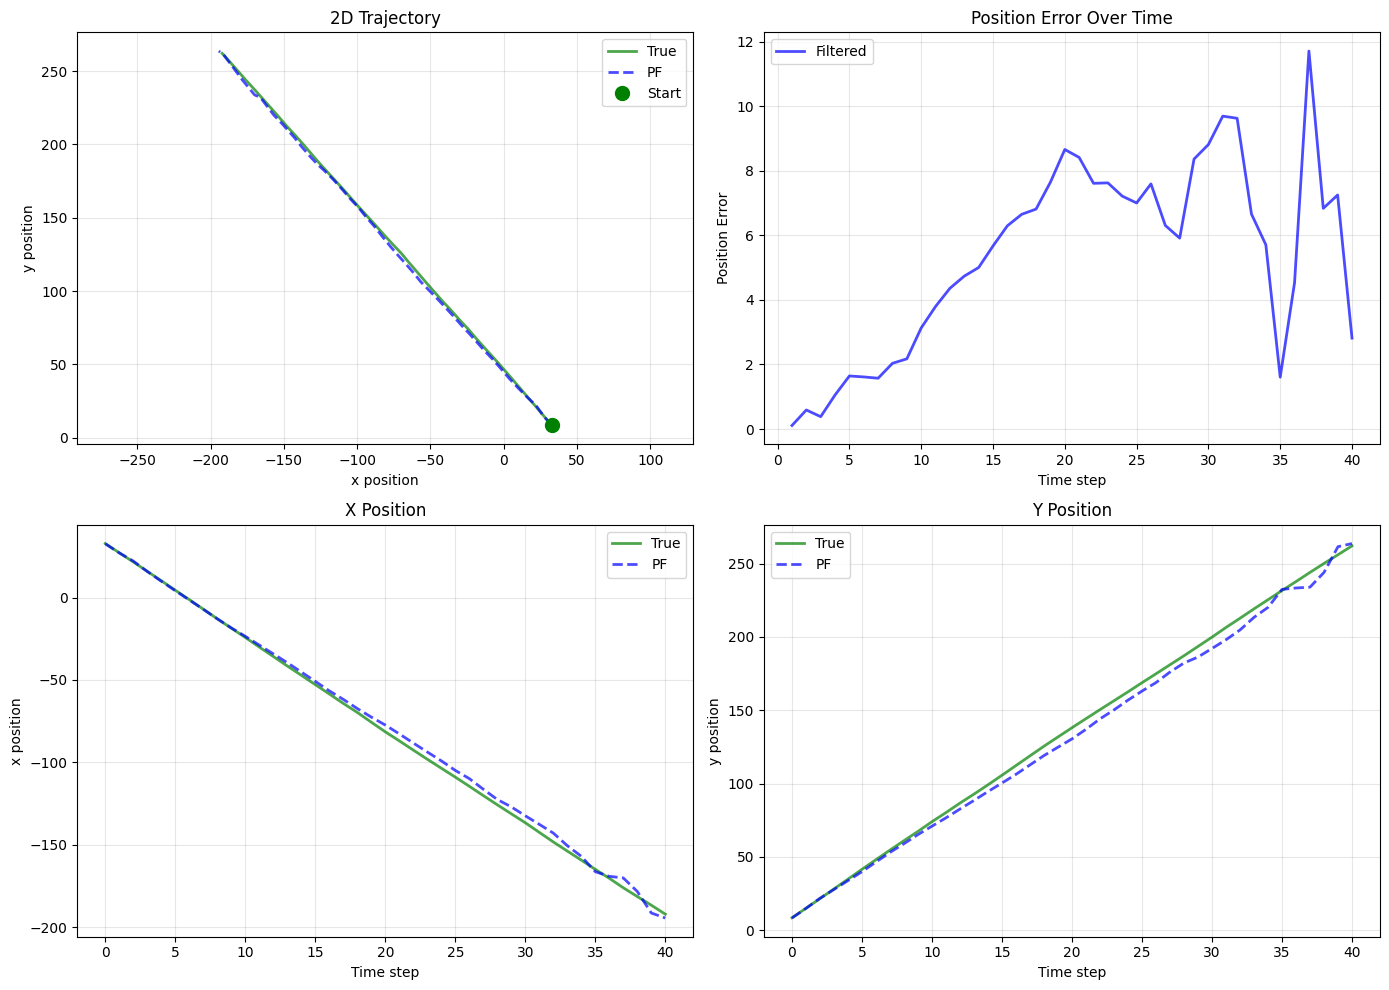

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Convert filtered states to numpy for plotting
filtered_np = filtered_states_f32.numpy()
true_np = true_states.numpy()

# 2D Trajectory
ax = axes[0, 0]
ax.plot(true_np[0, :], true_np[2, :], 'g-', linewidth=2, label='True', alpha=0.7)
ax.plot(filtered_np[0, :], filtered_np[2, :], 'b--', linewidth=2, label='PF', alpha=0.7)
ax.plot(true_np[0, 0], true_np[2, 0], 'go', markersize=10, label='Start')
ax.set_xlabel('x position')
ax.set_ylabel('y position')
ax.set_title('2D Trajectory')
ax.grid(True, alpha=0.3)
ax.legend()
ax.axis('equal')

# Position Error
ax = axes[0, 1]
time_steps = np.arange(1, T+1)
ax.plot(time_steps, pos_error_filtered.numpy(), 'b-', linewidth=2, label='Filtered', alpha=0.7)
ax.set_xlabel('Time step')
ax.set_ylabel('Position Error')
ax.set_title('Position Error Over Time')
ax.grid(True, alpha=0.3)
ax.legend()

# X Position
ax = axes[1, 0]
state_time = np.arange(0, T+1)
ax.plot(state_time, true_np[0, :], 'g-', linewidth=2, label='True', alpha=0.7)
ax.plot(state_time, filtered_np[0, :], 'b--', linewidth=2, label='PF', alpha=0.7)
ax.set_xlabel('Time step')
ax.set_ylabel('x position')
ax.set_title('X Position')
ax.grid(True, alpha=0.3)
ax.legend()

# Y Position
ax = axes[1, 1]
ax.plot(state_time, true_np[2, :], 'g-', linewidth=2, label='True', alpha=0.7)
ax.plot(state_time, filtered_np[2, :], 'b--', linewidth=2, label='PF', alpha=0.7)
ax.set_xlabel('Time step')
ax.set_ylabel('y position')
ax.set_title('Y Position')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

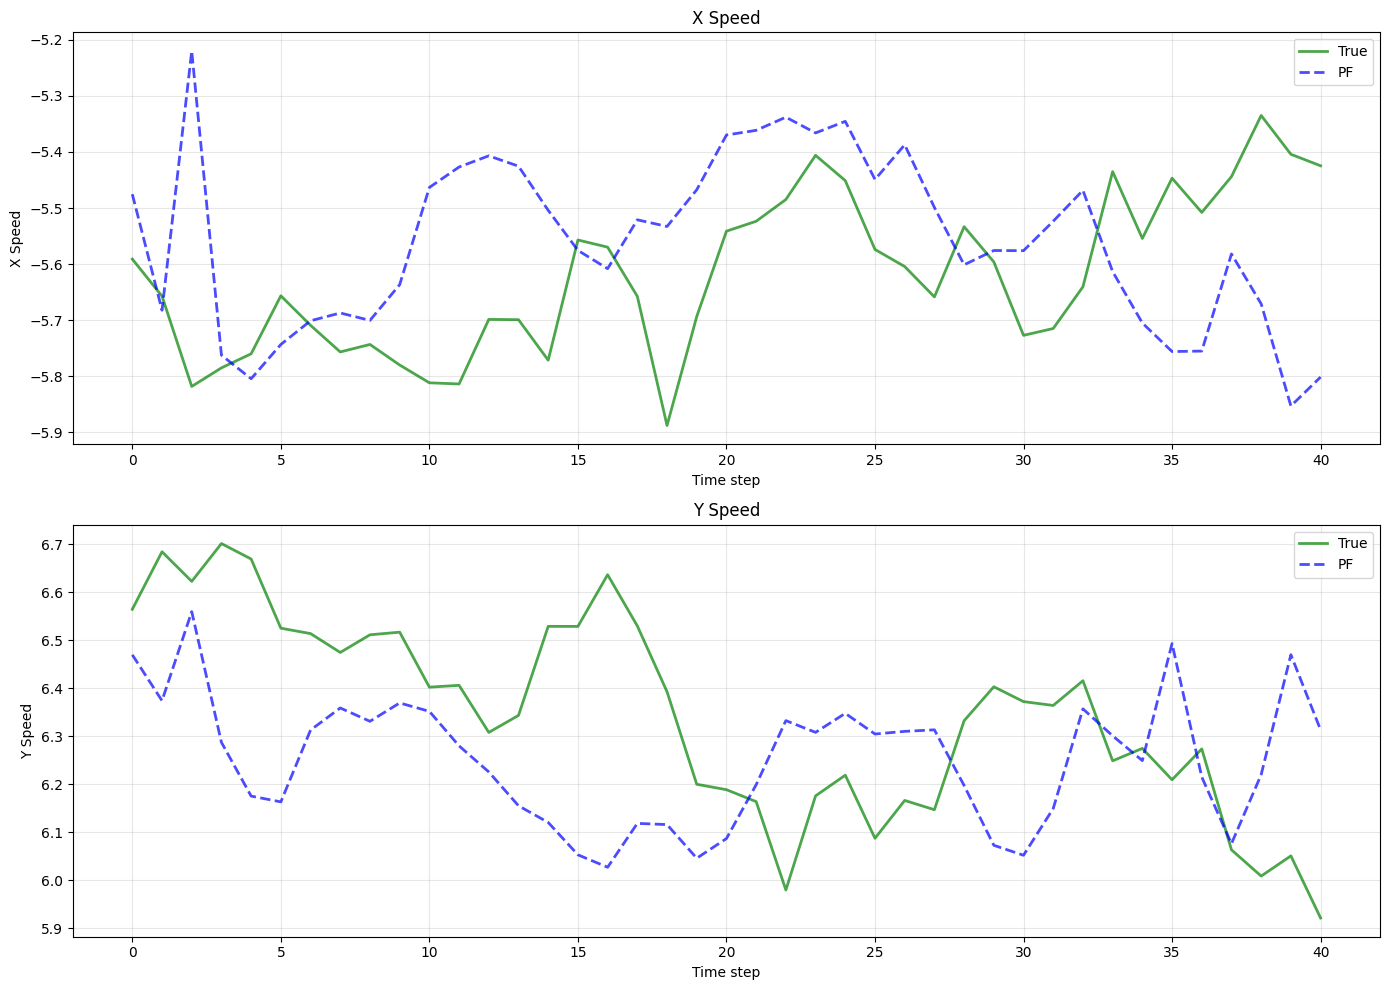

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# X Speed
ax = axes[0]
state_time = np.arange(0, T+1)
ax.plot(state_time, true_np[1, :], 'g-', linewidth=2, label='True', alpha=0.7)
ax.plot(state_time, filtered_np[1, :], 'b--', linewidth=2, label='PF', alpha=0.7)
ax.set_xlabel('Time step')
ax.set_ylabel('X Speed')
ax.set_title('X Speed')
ax.grid(True, alpha=0.3)
ax.legend()

# Y Speed
ax = axes[1]
ax.plot(state_time, true_np[3, :], 'g-', linewidth=2, label='True', alpha=0.7)
ax.plot(state_time, filtered_np[3, :], 'b--', linewidth=2, label='PF', alpha=0.7)
ax.set_xlabel('Time step')
ax.set_ylabel('Y Speed')
ax.set_title('Y Speed')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## 6. Visualize Particle Degeneracy

Particle degeneracy occurs when most particle weights become negligible, leaving only a few particles with significant weights. This is monitored using:
- **Effective Sample Size (ESS)**: N_eff = 1 / Σ(w_i²)
- **Weight Distribution**: Visualization of particle weight concentration over time

In [ ]:
import numpy as np


In [ ]:
    def reconstruct_particle_paths(self, particles_history, ancestry_history):
        """
        Reconstruct full particle trajectories from particles and ancestry history.

        This function traces back through the ancestry to build complete particle paths,
        showing the genealogy of particles. Useful for visualizing path degeneracy.

        Args:
            particles_history: Particle history (state_dim, num_particles, T+1)
            ancestry_history: Ancestry indices (num_particles, T+1)

        Returns:
            reconstructed_paths: Full particle paths (state_dim, num_particles, T+1)
                where reconstructed_paths[:, i, t] is the state at time t for the
                genealogy of particle i at the final time step
        """
        state_dim, num_particles, T_plus_1 = particles_history.shape
        T = T_plus_1 - 1

        # Initialize output with final particles
        reconstructed_paths = np.zeros((state_dim, num_particles, T_plus_1))

        # For each final particle, trace back its ancestry
        for i in range(num_particles):
            current_idx = i

            # Trace backwards from time T to 0
            for t in range(T, -1, -1):
                # Get the particle at time t for this lineage
                reconstructed_paths[:, i, t] = particles_history[:, current_idx, t]

                # Move to parent at previous time step
                if t > 0:
                    current_idx = int(ancestry_history[current_idx, t])

        return reconstructed_paths

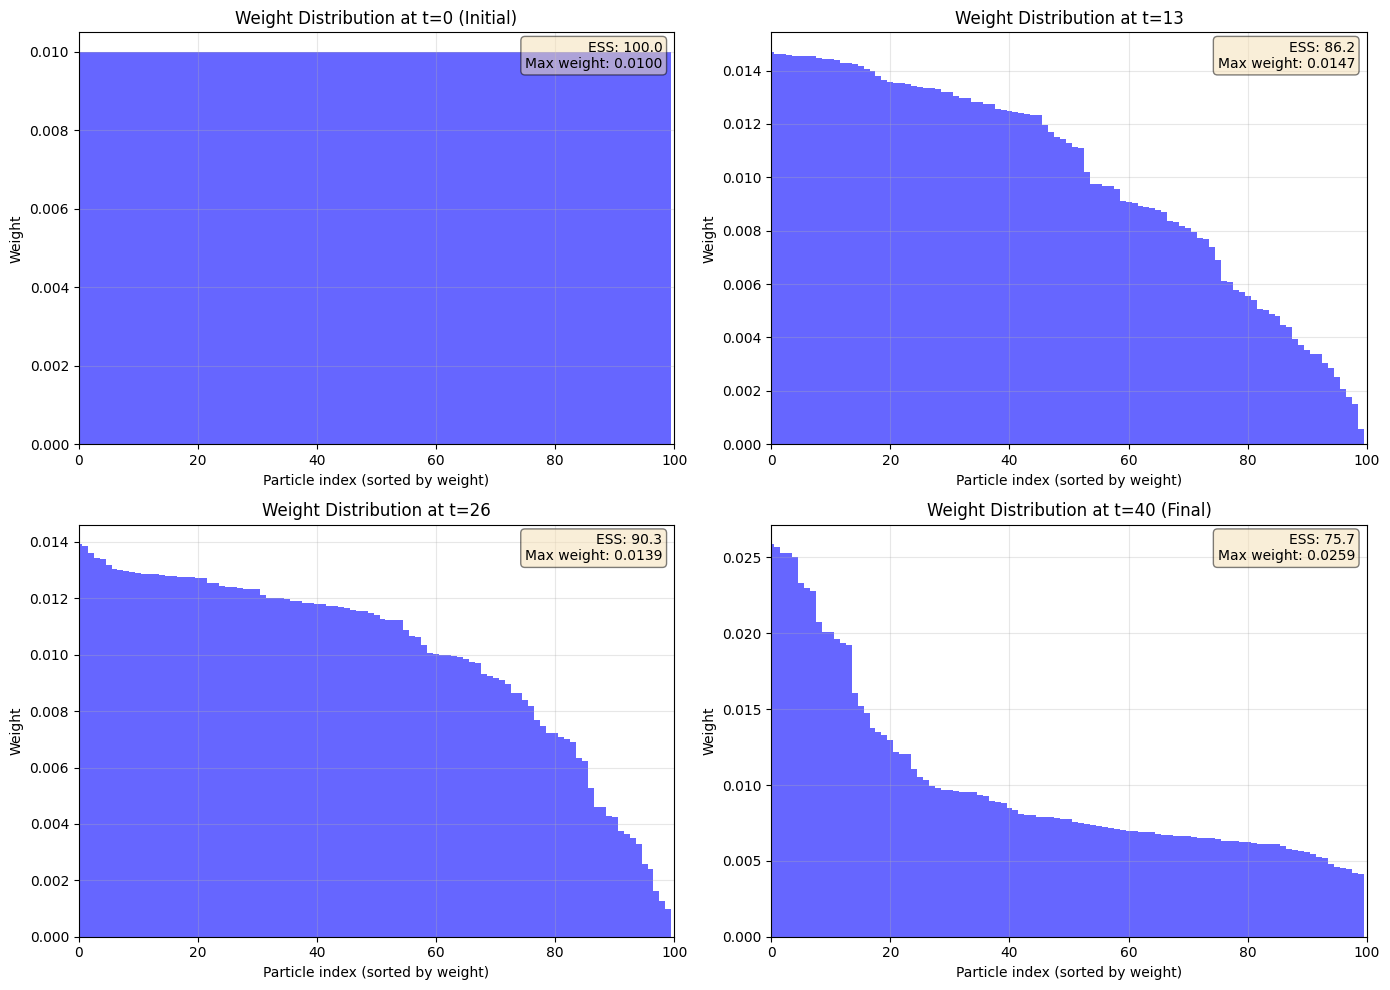

In [18]:
# Visualize weight distribution at different time steps
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Select time steps to visualize
time_indices = [0, T//3, 2*T//3, T]
titles = ['t=0 (Initial)', f't={T//3}', f't={2*T//3}', f't={T} (Final)']

for idx, (t_idx, title) in enumerate(zip(time_indices, titles)):
    ax = axes[idx // 2, idx % 2]
    
    # Get weights at this time step
    weights_t = weights_history[:, t_idx].numpy()
    
    # Sort weights in descending order
    sorted_weights = np.sort(weights_t)[::-1]
    
    # Plot weight distribution
    ax.bar(range(len(sorted_weights)), sorted_weights, width=1.0, color='blue', alpha=0.6)
    ax.set_xlabel('Particle index (sorted by weight)')
    ax.set_ylabel('Weight')
    ax.set_title(f'Weight Distribution at {title}')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, min(100, pf.num_particles)])  # Show only first 100 particles
    
    # Add statistics
    ess_t = ess_history[t_idx].numpy()
    max_weight = np.max(weights_t)
    ax.text(0.98, 0.98, f'ESS: {ess_t:.1f}\nMax weight: {max_weight:.4f}',
            transform=ax.transAxes, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()